In [1]:
import pandas as pd
import numpy as np
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import copy

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

In [2]:
count_file = 'data/keywords_daily_count.csv'

In [3]:
df = pd.read_csv(count_file)
df = df.convert_dtypes()

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
dg = df.groupby(pd.Grouper(freq='MS')).sum()
dg = dg[dg.index >= pd.Timestamp(2008,1,1)]

# Log transformations. Now doing that in the plots themselves
dl = copy.deepcopy(dg)
dl[['MeToo', 'BLM', 'OscarsSoWhite', 'OscarsSoWhite -BLM']] = np.log(dg[['MeToo', 'BLM', 'OscarsSoWhite', 'OscarsSoWhite -BLM']].replace(0, np.nan))
dl.fillna(0, inplace=True)
dl.clip(lower=0, inplace=True)

In [161]:
dm = pd.melt(dg.reset_index(), id_vars='Date', 
             value_vars=['MeToo', 'BLM', 'OscarsSoWhite'], 
             var_name="Movement", value_name="Monthly Tweets")
dm =dm.convert_dtypes()

In [162]:
dl = pd.melt(dl.reset_index(), id_vars='Date', 
             value_vars=['MeToo', 'BLM', 'OscarsSoWhite'], 
             var_name="Movement", value_name="Monthly Tweets")
dl =dl.convert_dtypes()

In [163]:
dm.head()

,Date,Movement,Monthly Tweets
0,2008-01-01,MeToo,36
1,2008-02-01,MeToo,18
2,2008-03-01,MeToo,23
3,2008-04-01,MeToo,65
4,2008-05-01,MeToo,34


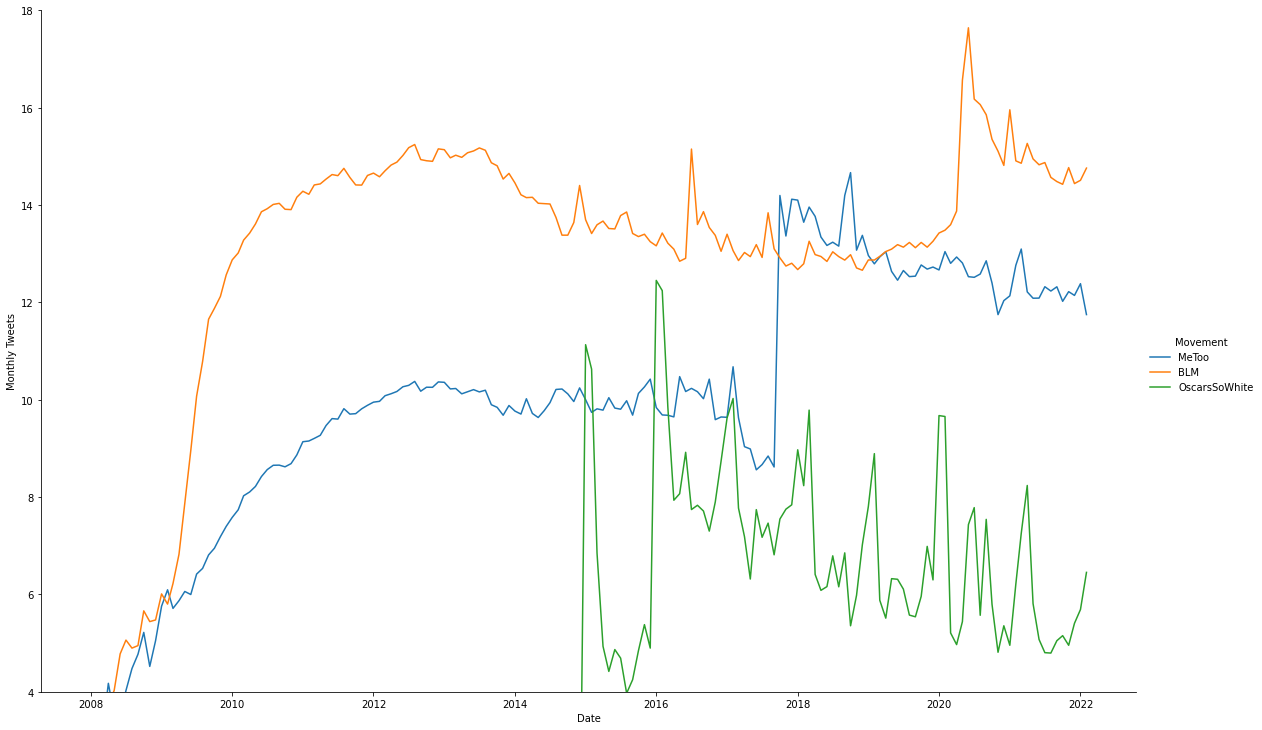

In [164]:
fig = sns.relplot(x='Date', y="Monthly Tweets", hue="Movement", data=dl, kind="line", height=10, aspect=1.6)
fig.set(ylim=(4,18))

plt.show()

In [165]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

In [166]:
# Okabe Ito colors
REGION_COLS = ["#E69F00", "#56B4E9", "#009E73"] #, "#F0E442", "#0072B2"]

# Category values for the colors
CATEGORY_CODES = pd.Categorical(dm["Movement"]).codes

# Select colors for each region according to its category.
COLORS = np.array(REGION_COLS)[CATEGORY_CODES]

# Compute colors for the edges: simply darker versions of the original colors
EDGECOLORS = [adjust_lightness(color, 0.6) for color in COLORS] 

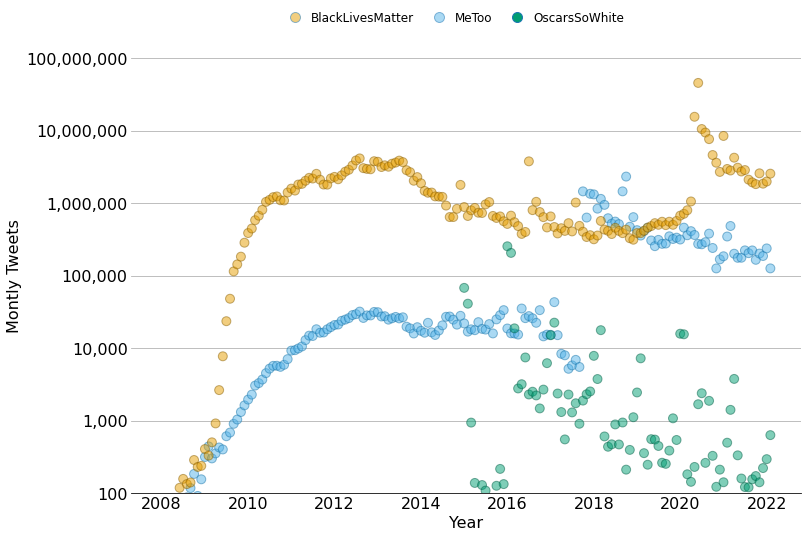

In [167]:
# Set default font size to 16
plt.rcParams.update({"font.size": "16"})

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(
    dm["Date"], dm["Monthly Tweets"], color=COLORS, edgecolors=EDGECOLORS,
    s=80, alpha=0.5, zorder=10
)
# zorder = 10 is used to make sure markers are on top of the regression line added later

plt.yscale('log', base=np.e)

plt.ylim(100, 70000000)

ticks = [100,1000,10000,100000,1000000,10000000,100000000]
tick_labels = [f'{value:,}' for value in ticks]

ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)

# Set y limits and y ticks
#ax.set(ylim=(2,18))
#ax.set_yticks(np.arange(2, 20, 2))

# Remove tick marks on both x and y axes
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

# Add grid lines, only for y axis
ax.grid(axis="y")

# Remove all spines but keep the bottom one
ax.spines["left"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# And finally set labels
ax.set_xlabel("Year")
ax.set_ylabel("Montly Tweets")

# Create handles -------------------------------------------------
# Region names with linebreaks for the long ones
REGIONS = [
    "BlackLivesMatter", "MeToo", "OscarsSoWhite"
]

# Create handles for lines.
handles = [
    Line2D(
        [], [], label=label, 
        lw=0, # there's no line added, just the marker
        marker="o", # circle marker
        markersize=10, 
        markerfacecolor=REGION_COLS[idx], # marker fill color
    )
    for idx, label in enumerate(REGIONS)
]

# Append a handle for the line
# handles += [Line2D([], [], label="y ~ log(x)", color="#696969", lw=2)]

# Add legend -----------------------------------------------------
legend = fig.legend(
    handles=handles,
    bbox_to_anchor=[0.5, 0.95], # Located in the top-mid of the figure.
    fontsize=12,
    handletextpad=0.6, # Space between text and marker/line
    handlelength=1.4, 
    columnspacing=1.4,
    loc="center", 
    ncol=3,
    frameon=False
)

# Set transparency -----------------------------------------------
# Iterate through first five handles and set transparency
for i in range(2): 
    handle = legend.legendHandles[i]
    handle._legmarker.set_alpha(0.5)

plt.show()